# Imports

In [2]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


In [3]:
!pip install googleimagedownloader
from googleimagedownloader.googleimagedownloader import GoogleImageDownloader

  Created wheel for requests-futures: filename=requests_futures-1.0.0-cp36-none-any.whl size=7012 sha256=cfb1b6f63befb46d67ef42dbfec9563c83508d49120455be38719558effa5a8d
  Stored in directory: /root/.cache/pip/wheels/26/d0/f5/dc4e4a37bbe55c9acf967d2bd899152412c1e49c227f5395ff
Successfully built requests-futures


# Testing an existing classifier

In [0]:
IMAGE_SIZE = (224, 224)

In [0]:
classifier_url ="https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4" 

In [0]:
classifier = Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SIZE+(3,))
])

90112/86910 [===============================] - 0s 0us/step


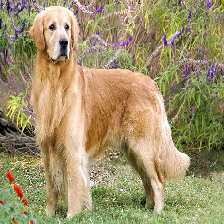

In [11]:
test_image = get_file('img.jpg','https://disenlis.com/wp-content/uploads/2019/01/Golden-Retriever-Standing1.jpg')
test_image = Image.open(test_image).resize(IMAGE_SIZE)
test_image

In [12]:
test_image = np.array(test_image)/255.0
test_image.shape

(224, 224, 3)

In [13]:
result = classifier.predict(test_image[np.newaxis, ...])
result.shape

(1, 1001)

In [14]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

208

In [15]:
labels_path = get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


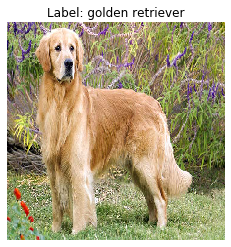

In [16]:
predicted_class_name = imagenet_labels[predicted_class]

plt.axis('off')
plt.title("Label: " + predicted_class_name, color = 'black')
plt.imshow(test_image)
plt.show()

# Transfer Learning

## Build the dataset

In [0]:
class_names = ['ferrari','ford']
path = 'dataset/'

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

train_ferrari_dir = os.path.join(train_dir, 'ferrari')  
train_ford_dir = os.path.join(train_dir, 'ford')  
validation_ferrari_dir = os.path.join(validation_dir, 'ferrari') 
validation_ford_dir = os.path.join(validation_dir, 'ford')  

if os.path.exists(path):
  shutil.rmtree(path)

os.makedirs(train_ferrari_dir)
os.makedirs(train_ford_dir)
os.makedirs(validation_ferrari_dir)    
os.makedirs(validation_ford_dir)

In [0]:
def manage_images(src, dest_train, dest_val, image_resize=IMAGE_SIZE, val_split=0.1, prefix=''):
  total = len(os.listdir(src))
  val = np.int(total*val_split)
  count = 0
  files = os.listdir(src)

  for file_name in files:
    try:
      dest = dest_train if count >= val else dest_val
      dest_file = os.path.join(dest, prefix + file_name) 

      img = Image.open(os.path.join(src,file_name))
      img.verify()
      # reopen because verify() was called
      # If you need to load the image after using this method, you must reopen the image file.
      # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
      img = Image.open(os.path.join(src,file_name))
      #resize
      img = img.resize(image_resize, Image.ANTIALIAS)
      #move
      img.save(dest_file)  
      count+=1 
    except Exception as e:
        print('Invalid image: ',file_name,e)
        if os.path.exists(dest_file):
          os.remove(dest_file)
  return


In [0]:
img_dir = os.path.realpath('Images/')

In [0]:
queries = ['f355','F40','laferrari','testarossa','enzo']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='ferrari '+query, numberImage=100)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_ferrari_dir, validation_ferrari_dir,prefix=str(pos)+'-')
  pos+=1

In [25]:
queries = ['mustang','gt40','escort','gt','transit']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='ford '+query, numberImage=100)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_ford_dir, validation_ford_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=ford mustang&source=lnms&tbm=isch
Total Time : 0:00:10.193324
Invalid image:  31.jpg cannot write mode RGBA as JPEG
Invalid image:  41.jpg cannot identify image file '/content/Images/41.jpg'
Invalid image:  43.jpg cannot identify image file '/content/Images/43.jpg'
https://www.google.co.in/search?q=ford gt40&source=lnms&tbm=isch
Total Time : 0:00:04.024721
Invalid image:  8.jpg cannot write mode RGBA as JPEG
Invalid image:  57.jpg cannot identify image file '/content/Images/57.jpg'
Invalid image:  64.jpg cannot write mode RGBA as JPEG
Invalid image:  68.jpg cannot write mode P as JPEG
Invalid image:  6.jpg cannot write mode RGBA as JPEG
Invalid image:  95.jpg cannot identify image file '/content/Images/95.jpg'
Invalid image:  28.jpg cannot identify image file '/content/Images/28.jpg'
Invalid image:  18.jpg cannot identify image file '/content/Images/18.jpg'
Invalid image:  5.jpg cannot write mode P as JPEG
Invalid image:  9.jpg cannot write mode RGBA a

In [26]:
total_train = len(os.listdir(train_ferrari_dir))+ len(os.listdir(train_ford_dir))
total_val = len(os.listdir(validation_ferrari_dir))+ len(os.listdir(validation_ford_dir))

print('total training Ferrari images:', len(os.listdir(train_ferrari_dir)))
print('total training Ford images:', len(os.listdir(train_ford_dir)))

print('total validation Ferrari images:', len(os.listdir(validation_ferrari_dir)))
print('total validation Ford images:', len(os.listdir(validation_ford_dir)))
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training Ferrari images: 425
total training Ford images: 406
total validation Ferrari images: 51
total validation Ford images: 50
--
Total training images: 831
Total validation images: 101


## Using the dataset

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [28]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE,
                                                           class_mode='binary')

Found 831 images belonging to 2 classes.


In [29]:
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='binary')

Found 101 images belonging to 2 classes.


## Testing the classifier

In [0]:
image_batch, labels_batch = next(train_data_gen)

In [31]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [32]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['sports car', 'sports car', 'beach wagon', 'sports car',
       'sports car', 'sports car', 'sports car', 'sports car',
       'sports car', 'sports car', 'sports car', 'convertible',
       'sports car', 'racer', 'sports car', 'convertible', 'sports car',
       'convertible', 'sports car', 'pickup', 'sports car', 'sports car',
       'racer', 'sports car', 'beach wagon', 'sports car', 'racer',
       'sports car', 'sports car', 'sports car', 'minivan', 'sports car'],
      dtype='<U30')

In [0]:
def plot_images(img_batch, labels, predicted_labels):
  plt.figure(figsize=(12,12))
  plt.subplots_adjust(hspace=0.5)
  for i in range(15):
    plt.subplot(6,5,i+1) 
    plt.imshow(img_batch[i])
    color = "green" if predicted_labels[i] == class_names[np.int(labels[i])] else "red"
    plt.title(predicted_labels[i], color=color)
    plt.axis('off')

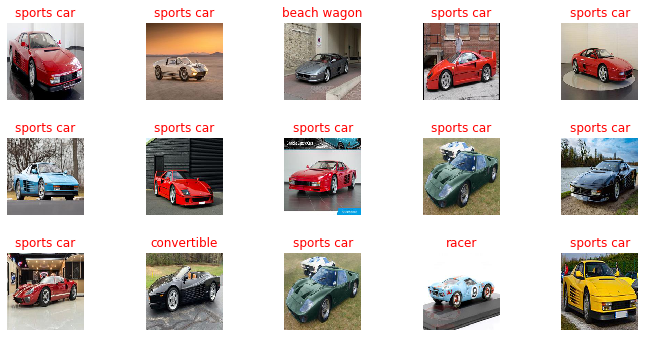

In [34]:
plot_images(image_batch, labels_batch, predicted_class_names)

## Downloading headless model

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SIZE+(3,))

In [37]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [0]:
feature_extractor_layer.trainable = False

## Adding a classification head

In [39]:
model = Sequential([
  feature_extractor_layer,
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


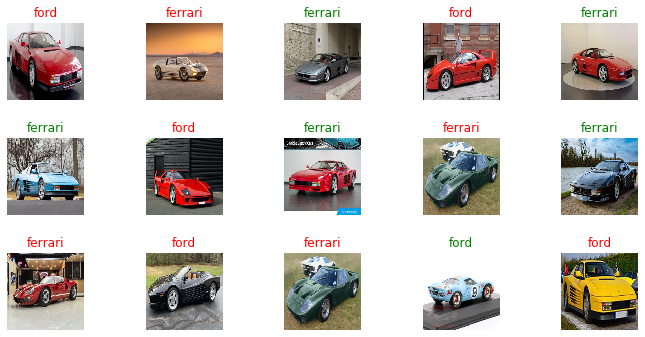

In [40]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

## Train the model

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_data=val_data_gen
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 4 steps
Epoch 1/5
5/5 [==============================] - 28s 6s/step - loss: 0.6946 - accuracy: 0.7125 - val_loss: 1.0172 - val_accuracy: 0.6238
Epoch 2/5
5/5 [==============================] - 25s 5s/step - loss: 0.5593 - accuracy: 0.8188 - val_loss: 0.7458 - val_accuracy: 0.8911
Epoch 3/5
5/5 [==============================] - 25s 5s/step - loss: 0.1846 - accuracy: 0.9308 - val_loss: 0.5958 - val_accuracy: 0.7525
Epoch 4/5
5/5 [==============================] - 25s 5s/step - loss: 0.2229 - accuracy: 0.9125 - val_loss: 0.3939 - val_accuracy: 0.9010
Epoch 5/5
5/5 [==============================] - 25s 5s/step - loss: 0.1162 - accuracy: 0.9438 - val_loss: 0.2422 - val_accuracy: 0.9010


## Check results

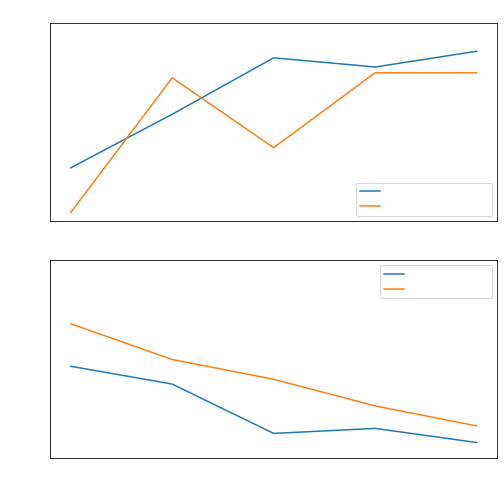

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

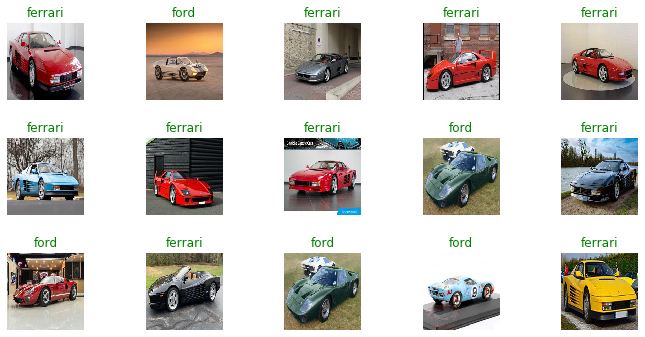

In [45]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()

plot_images(image_batch, labels_batch, predicted_class_names)

##Application base model

In [46]:
base_model = ResNet50V2(input_shape=IMAGE_SIZE+(3,),
                                               include_top=False,
                                               weights='imagenet')

94674944/94668760 [==============================] - 3s 0us/step


In [0]:
base_model.trainable = False

In [48]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [49]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')    
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [51]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_data=val_data_gen
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 4 steps
Epoch 1/5
5/5 [==============================] - 33s 7s/step - loss: 0.6941 - accuracy: 0.7312 - val_loss: 1.1828 - val_accuracy: 0.6436
Epoch 2/5
5/5 [==============================] - 31s 6s/step - loss: 0.1336 - accuracy: 0.9500 - val_loss: 2.2988 - val_accuracy: 0.5644
Epoch 3/5
5/5 [==============================] - 30s 6s/step - loss: 0.1011 - accuracy: 0.9750 - val_loss: 1.3858 - val_accuracy: 0.7030
Epoch 4/5
5/5 [==============================] - 31s 6s/step - loss: 0.2041 - accuracy: 0.9125 - val_loss: 2.2921 - val_accuracy: 0.6238
Epoch 5/5
5/5 [==============================] - 30s 6s/step - loss: 0.0304 - accuracy: 0.9937 - val_loss: 3.0009 - val_accuracy: 0.5842


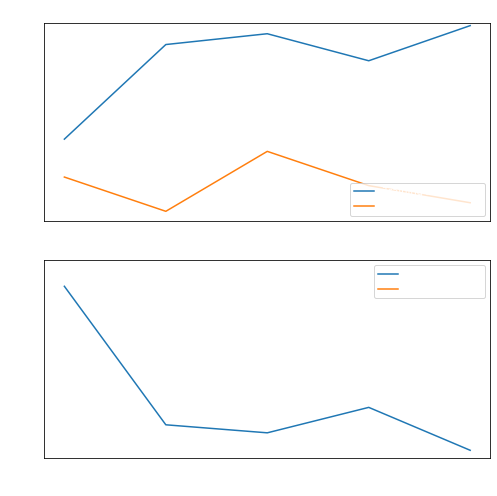

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.8])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

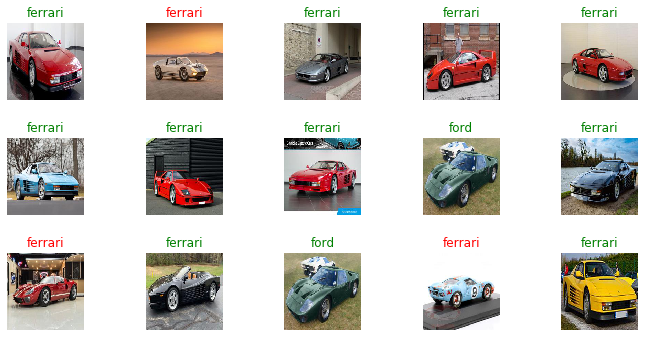

In [53]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

## Fine tuning

In [0]:
base_model.trainable = True

In [55]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 160
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  190


In [56]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 16,542,721
Non-trainable params: 9,121,280
_________________________________________________________________


In [57]:
initial_epochs = 5
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=5,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_data_gen)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 4 steps
Epoch 5/10
5/5 [==============================] - 47s 9s/step - loss: 0.4465 - accuracy: 0.8813 - val_loss: 4.4022 - val_accuracy: 0.7030
Epoch 6/10
5/5 [==============================] - 42s 8s/step - loss: 0.2104 - accuracy: 0.9187 - val_loss: 1.9606 - val_accuracy: 0.8812
Epoch 7/10
5/5 [==============================] - 43s 9s/step - loss: 0.0704 - accuracy: 0.9812 - val_loss: 6.7045 - val_accuracy: 0.8020
Epoch 8/10
5/5 [==============================] - 43s 9s/step - loss: 0.0614 - accuracy: 0.9750 - val_loss: 14.1858 - val_accuracy: 0.8020
Epoch 9/10
5/5 [==============================] - 43s 9s/step - loss: 0.0273 - accuracy: 0.9875 - val_loss: 26.5326 - val_accuracy: 0.6931
Epoch 10/10
5/5 [==============================] - 44s 9s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 24.9448 - val_accuracy: 0.6931


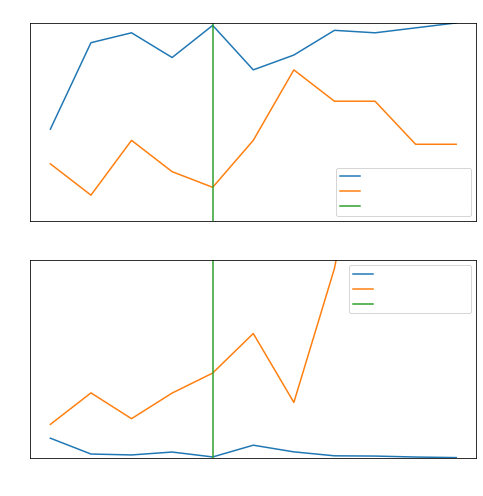

In [58]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 7.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

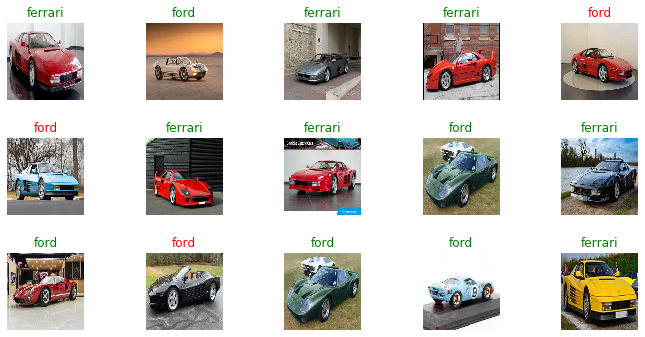

In [59]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)